In [ ]:
  from google.colab import drive
from os.path import join

ROOT = '/content/drive'     # default for the drive
PROJ = 'MyDrive/OLSPE'       # path to your project on Drive

drive.mount(ROOT)           # we mount the drive at /content/drive

PROJECT_PATH = join(ROOT, PROJ)
!mkdir "{PROJECT_PATH}"    # in case we haven't created it already
%cd "{PROJECT_PATH}"

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/OLSPE’: File exists
/content/drive/MyDrive/OLSPE


1. IMPORTATION DES LIBRARIES UTILISEES

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
from PIL import Image

from keras.models import Sequential, Model
from keras.layers import Flatten, Dropout, Activation, Permute
from keras.layers import Convolution2D, MaxPooling2D
from keras import backend as K
K.set_image_data_format( 'channels_last' )
from scipy.spatial.distance import cosine as dcos
from scipy.io import loadmat
import os
from multiprocessing.dummy import Pool
from keras.preprocessing.image import img_to_array, array_to_img
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import sys

2. PRISE DE CAPTURE A PARTIR DE LA CAMERA


In [ ]:
# Lancer la caméra et prendre la photo



VIDEO_HTML = """
<video autoplay
 width=%d height=%d style='cursor: pointer;'></video>
<script>

var video = document.querySelector('video')

navigator.mediaDevices.getUserMedia({ video: true })
  .then(stream=> video.srcObject = stream)
  
var data = new Promise(resolve=>{
  video.onclick = ()=>{
    var canvas = document.createElement('canvas')
    var [w,h] = [video.offsetWidth, video.offsetHeight]
    canvas.width = w
    canvas.height = h
    canvas.getContext('2d')
          .drawImage(video, 0, 0, w, h)
    video.srcObject.getVideoTracks()[0].stop()
    video.replaceWith(canvas)
    resolve(canvas.toDataURL('image/jpeg', %f))
  }
})
</script>
"""
#FONCTION DE DEMARRAGE DE LA CAMERA
#clicquer dans la vidéo pour faire une capture d'image
def take_photo2(filename='photo.jpg', quality=0.8, size=(800,600)):
  display(HTML(VIDEO_HTML % (size[0],size[1],quality)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  f = io.BytesIO(binary)
  return np.asarray(Image.open(f))

3. OUVERTURE DE LA CAMERA


In [ ]:
img = take_photo2() # click

3.AFFICHAGE DE LA PHOTO PRISE PAR LA CAMERA


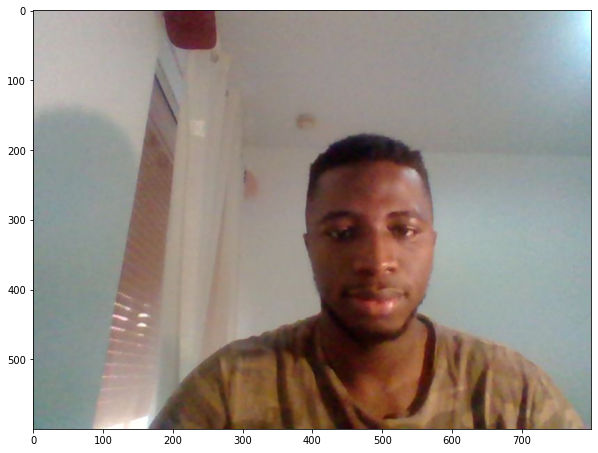

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

4.APPLICATION DE FILTRE SUR LA PHOTO ET DETECTION DU VISAGE


Il y a 1 visage(s).


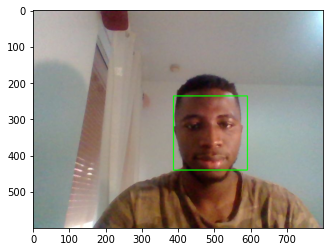

In [ ]:
 
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cascadefile = "/content/drive/MyDrive/haarcascade_frontalface_default.xml"
classCascade = cv2.CascadeClassifier(cascadefile)
faces = classCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.CASCADE_SCALE_IMAGE
)
print("Il y a {0} visage(s).".format(len(faces)))
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
 
plt.imshow(img)


5. AFFICHAGE DU CADRE DE L'IMAGE


In [ ]:
for i in range(len(faces)):
    print("Cadre du visage N°{0} --> {1}".format(i, faces[i]))

Cadre du visage N°0 --> [387 236 204 204]


6. AFFICHAGE DU VISAGE EXTRAIT DE L'IMAGE


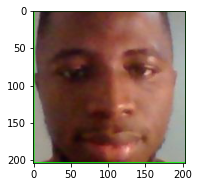

In [ ]:
for i in range(len(faces)):
    plt.subplot(1, 2, i+1)
    plt.imshow(img[faces[i][1]:faces[i][1]+faces[i][3], faces[i][0]:faces[i][0]+faces[i][2]])

7. RECONNAISSANCE DU VISAGE DANS LA BANQUES D'IMAGES

In [ ]:
def convblock(cdim, nb, bits=3):
    L = []
    for k in range(1,bits+1):
        convname = 'conv'+str(nb)+'_'+str(k)
        L.append( Convolution2D(cdim, kernel_size=(3, 3), padding='same', activation='relu', name=convname) )
    L.append( MaxPooling2D((2, 2), strides=(2, 2)) )
    return L
 
def vgg_face_blank():
    withDO = True # no effect during evaluation but usefull for fine-tuning
    if True:
        mdl = Sequential()
        mdl.add( Permute((1,2,3), input_shape=(224,224,3)) )
        for l in convblock(64, 1, bits=2):
            mdl.add(l)
        for l in convblock(128, 2, bits=2):
            mdl.add(l)        
        for l in convblock(256, 3, bits=3):
            mdl.add(l)            
        for l in convblock(512, 4, bits=3):
            mdl.add(l)            
        for l in convblock(512, 5, bits=3):
            mdl.add(l)        
        mdl.add( Convolution2D(4096, kernel_size=(7, 7), activation='relu', name='fc6') )
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(4096, kernel_size=(1, 1), activation='relu', name='fc7') )
        if withDO:
            mdl.add( Dropout(0.5) )
        mdl.add( Convolution2D(2622, kernel_size=(1, 1), activation='relu', name='fc8') )
        mdl.add( Flatten() )
        mdl.add( Activation('softmax') )
        
        return mdl
    
    else:
        raise ValueError('not implemented')

In [ ]:
def copy_mat_to_keras(kmodel):
    kerasnames = [lr.name for lr in kmodel.layers]
    prmt = (0,1,2,3)
 
    for i in range(l.shape[1]):
        matname = l[0,i][0,0].name[0]
        if matname in kerasnames:
            kindex = kerasnames.index(matname)
            l_weights = l[0,i][0,0].weights[0,0]
            l_bias = l[0,i][0,0].weights[0,1]
            f_l_weights = l_weights.transpose(prmt)
            assert (f_l_weights.shape == kmodel.layers[kindex].get_weights()[0].shape)
            assert (l_bias.shape[1] == 1)
            assert (l_bias[:,0].shape == kmodel.layers[kindex].get_weights()[1].shape)
            assert (len(kmodel.layers[kindex].get_weights()) == 2)
            kmodel.layers[kindex].set_weights([f_l_weights, l_bias[:,0]])

In [ ]:
# CNN model initialization
facemodel = vgg_face_blank()
# Load the pretrained weights into the model
data = loadmat("/content/drive/MyDrive/vgg-face.mat", matlab_compatible=False, struct_as_record=False)
l = data['layers']
description = data['meta'][0,0].classes[0,0].description
 
copy_mat_to_keras(facemodel)
# Final model that can get inputs and generate a prediction as an output
featuremodel = Model(inputs = facemodel.layers[0].input, outputs = facemodel.layers[-2].output)

In [ ]:
#REDIMENSIONNER L'IMAGE
"""
x = img.astype("float32")
imge = np.expand_dims(x,axis=1)
image = np.reshape(imge, (None, 1, 800, 3))
featuremodel.predict(imge)
"""

8. DETECTION DU MOUVEMENT DU VISAGE

9. DETECTION D'OBJETS EN FACE DU CANDIDAT